# entrainement model Keras fonction Sigmoid

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

c:\Users\nperc\Documents\Datathon\01_iHeath_env2\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\nperc\Documents\Datathon\01_iHeath_env2\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\nperc\Documents\Datathon\01_iHeath_env2\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
dir_path        = 'C:\\Users\\nperc\\Documents\\Datathon\\clean_deep_model'

In [3]:
dir_images      = os.path.join(dir_path, 'data\\images\\sup')

### Parameters

In [15]:
SIZE        = 224
IMAGE_SIZE  = (SIZE, SIZE, 1)

In [16]:
# import cv2 as cv
# from tensorflow.keras.preprocessing.image import load_img, img_to_array

# X        = []
# y        = []

# dir_new = os.path.join(dir_path, 'data\\images\\sup')

# for dir_client in os.listdir(dir_images) :
#     path_client = os.path.join(dir_images, dir_client)
#     for dirs in os.listdir(path_client) :
#         if dirs.lower().find('sup') != -1 :
#             image = cv.imread(os.path.join(path_client, dirs))
#             # image = cv.resize(image, (SIZE, SIZE), interpolation = cv.INTER_LINEAR)
           
           

#             # if(image[image.astype(bool)].size != 0) :            
#             #     try :
#             #         y.append(dataset['CHA2DS2_VASc'][dataset['Num patient'] == dir_client].values[0])
#             #         X.append(image)
                    
#             #     except :
#             #         print(dir_client + ' --> not found')
#             #         continue

In [17]:
batch_size = 4

# train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
#     dir_images,
#     validation_split=0.2,
#     subset="both",
#     seed=1337,
#     image_size=(SIZE, SIZE),
#     batch_size=batch_size,
#     label_mode='categorical'
# )

In [18]:
import rerun as rr
import numpy.typing as npt

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
            dir_images,
            labels='inferred',
            label_mode='categorical',
            class_names=None,
            color_mode='grayscale',
            batch_size=batch_size,
            image_size=(SIZE, SIZE),
            shuffle=True,
            seed=42,
            validation_split=0.2,
            subset='both',
            interpolation='bilinear',
            follow_links=False,
            crop_to_aspect_ratio=False
        )

options = tf.data.Options()
options.threading.max_intra_op_parallelism = 1
train_ds    = train_ds.with_options(options)

# ------------------------------------------------
val_ds   	= val_ds.with_options(options)
# val_ds   	= val_ds.cache().repeat( 50 ).prefetch( buffer_size = 50)

# # ------------------------------------------------
# train_ds = train_ds.cache().repeat( 50 ).prefetch( buffer_size = 50)


Found 736 files belonging to 3 classes.
Using 589 files for training.
Using 147 files for validation.


In [19]:
# data_augmentation = keras.Sequential(
#     [
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(0.1),
#     ]
# )

# augmented_train_ds = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [20]:
train_ds    = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds      = val_ds.prefetch(tf.data.AUTOTUNE)

# Construction du modèle

In [21]:
# def make_model(input_shape, num_classes):
#     inputs = keras.Input(shape=input_shape)

#     x = tf.keras.applications.DenseNet201(weights=None)(inputs)


#     x = layers.Dropout(0.5)(x)
#     outputs = layers.Dense(num_classes, activation="softmax")(x)
#     return keras.Model(inputs, outputs)


# model = make_model(input_shape=IMAGE_SIZE, num_classes=3)

In [28]:
from keras import layers, models
from keras.applications import *
from keras.applications.efficientnet import EfficientNetB0
from keras.initializers import RandomNormal

init = RandomNormal(mean=0.0, stddev=0.02, seed=None)
NUMBER_OF_CLASSES = 3

def make_model( IMG_SHAPE ):
    conv_base = DenseNet201(weights=None, include_top=False, input_shape=IMG_SHAPE)
    model     = models.Sequential()
    model.add(conv_base)
    model.add(layers.GlobalMaxPooling2D(name="gap"))
    #avoid overfitting
    model.add(layers.Dropout(0.2, name="dropout_out"))
    model.add(layers.Dense(32, activation='relu'))
    # Set NUMBER_OF_CLASSES to the number of your final predictions.
    model.add(layers.Dense(NUMBER_OF_CLASSES, activation="softmax", name="fc_out", kernel_initializer=init, use_bias=False))
    conv_base.trainable = False

    return model


model = make_model(IMG_SHAPE=IMAGE_SIZE)

In [23]:
# epochs = 50

# callbacks = [
#     keras.callbacks.ModelCheckpoint("cc/cc_{epoch}.keras"),
# ]
# model.compile(
#     optimizer=keras.optimizers.Adam(1e-3),
#     loss="categorical_crossentropy",
#     metrics=["accuracy"],
# )
# model.fit(
#     train_ds,
#     epochs=epochs,
#     callbacks=callbacks,
#     validation_data=val_ds,
# )

In [29]:
callbacks = [

    # ModelCheckpoint permet de sauvegarder le modèle après chaque epoch.
    keras.callbacks.ModelCheckpoint("sup/sup_{epoch}.keras"),

    # EarlyStopping permet d'arrêter l'entraînement prématurément si la perte (loss) sur l'ensemble
    # de validation ne s'améliore pas pendant un certain nombre d'epochs (patience).
    tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0),
    
    # ReduceLROnPlateau permet de réduire le taux d'apprentissage si la perte sur l'ensemble
    # de validation ne s'améliore pas pendant un certain nombre d'epochs (patience)
    tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0)
]

In [30]:
# from segmentation_models import Unet, get_preprocessing
# from segmentation_models.losses import bce_jaccard_loss
# from segmentation_models.metrics import iou_score

# BACKBONE = 'resnet34'
# preprocess_input = get_preprocessing(BACKBONE)


# # preprocess input
# train_ds = preprocess_input(train_ds)
# val_ds   = preprocess_input(val_ds)

# # define model
# model = Unet(BACKBONE, encoder_weights=None)
# model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

# # fit model
# model.fit(
#     train_ds,
#     epochs=10,
#     callbacks=callbacks,
#     validation_data=val_ds,
# )

# Entrainement du model

In [31]:
epochs      = 50

In [32]:
# Nombre d'itérations d'entraînement que le modèle va effectuer sur l'ensemble des données


# Fonctions qui sont exécutées pendant l'entraînement pour effectuer des opérations
# telles que sauvegarder le modèle ou ajuster le taux d'apprentissage


model.compile(
    optimizer=keras.optimizers.Adam(0.005),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)


history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/50


InvalidArgumentError: Graph execution error:

`channels` must be 0, 3 or 4 for BMP, but got 1
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_50171]

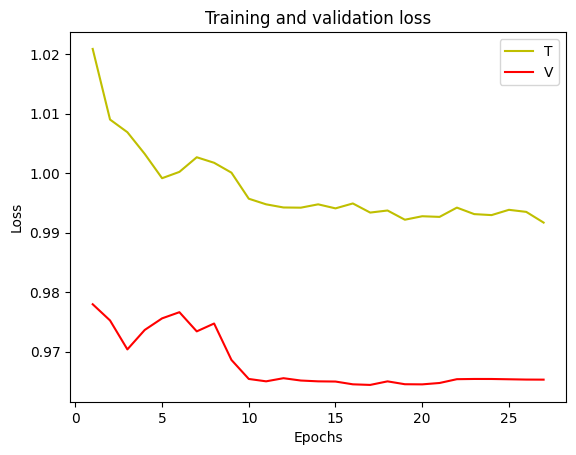

In [48]:
import matplotlib.pyplot as plt

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='T')
plt.plot(epochs, val_loss, 'r', label='V')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()